# Librerías y definición de funciones

In [2]:
import os
import numpy as np
import nibabel as nib
import random
from dipy.io.streamline import load_tractogram
from dipy.tracking.streamline import Streamlines
from dipy.segment.clustering import QuickBundles
from dipy.segment.metric import IdentityFeature
from dipy.segment.metric import AveragePointwiseEuclideanMetric
from dipy.io.pickles import save_pickle
from dipy.io.pickles import load_pickle
from dipy.data import get_fnames
from dipy.viz import window, actor
import time
import utils.bundleTools as bt
import utils.bundleTools3 as bt3

def display(streamlines, clusters=False, ids=False, hd=False, color = 'tab20'):
    ren = window.Renderer()
    ren.background((1, 1, 1))
    if(clusters):
        colormap = actor.create_colormap(np.arange(len(ids)), name=color, auto=True)
        #colormap = actor.create_colormap(np.arange(int(len(ids)/2)+1), name='tab20', auto=True)
        #colormap = [*colormap[:-1],*colormap[:-1], colormap[-1]]

        stream = []
        colors = []

        for i,id_ in enumerate(ids):
            for streamline in clusters[id_]:
                stream.append(streamlines[streamline])
                colors.append(colormap[i])#*len(streamlines[streamline]))
        if(hd):
            ren.add(actor.streamtube(stream, linewidth=0.1, colors=colors))
        else:
            ren.add(actor.line(stream, colors))
            
    else:
        if(hd):
            #ren.add(actor.line(streamlines, window.colors.black, opacity=0.05))
            ren.add(actor.streamtube(streamlines, linewidth=0.1, colors=[(0.4,0.698,1)]*len(streamlines)))
        else:
            ren.add(actor.line(streamlines))

    window.show(ren, size=(1200, 900))
    
byte_order = "DCBA"

def get_centroids(brain, sub, remove_little_ones=False, size=False, nearest=False):
    centroids = []
    original_data = []
    
    og_centroids = np.array(bt3.read_bundle_severalbundles(path + sub + '/Talairach/centroids_Tal.bundles')[0])
    
    if(remove_little_ones):
        removed1 = 0
        removed2 = 0
        for i,cluster in enumerate(brain):
            sz = len(cluster)
            if(sz >= remove_little_ones):
                centroid = og_centroids[i][0]
                if np.linalg.norm(centroid[0]-centroid[1]) > size:
                    centroids.append(centroid)
                    selected = random.sample(range(sz),int(sz*(nearest/100)))
                    original_data.append(np.array(cluster)[selected])
                else:
                    removed2 +=1
            else:
                removed1+=1
        print(str(removed1)+' and '+str(removed2)+' removed from '+str(len(brain))+'. '+str(len(centroids))+' remaining centroids.'+str(len(np.concatenate(brain)))+' remaining fibers')
    else:
        for cluster in brain:
            centroids.append(get_centroid(cluster))
            original_data.append(np.array(cluster))
    return centroids, np.array(original_data)

def random_palette(n):
    return [(random.randrange(0, 255), random.randrange(0, 255), random.randrange(0, 255)) for i in range(n)]

def write_hie(path,names,colors):
    f = open(path,"w")
    f.write("# tree 1.0\n\n*BEGIN TREE hierarchy\ngraph_syntax RoiArg\n\n*BEGIN TREE fold_name\nname ALL\n\n")
    for i,n in enumerate(names):
        f.write("*BEGIN TREE fold_name\n")
        f.write("name "+n+"\n")
        f.write("color "+str(colors[i][0])+" "+str(colors[i][1])+" "+str(colors[i][2])+"\n\n")
        f.write("*END\n\n")
    f.write("*END\n\n*END\n\n*END\n\n")
    f.close()


def write_header(path,bnames,intervals,dim,nfibers):
    f = open(path,"w")
    f.write("attributes = {\n    'binary' : 1,\n    'bundles' : ")
    f.write(str([val for pair in zip(bnames, intervals) for val in pair])+",\n")
    f.write("    'byte_order' : "+'\''+byte_order+'\',\n')
    f.write("    'curves_count' : "+str(nfibers)+",\n")
    f.write("    'data_file_name' : "+"\'*"+os.path.splitext(path+"data")[1]+"\',\n")
    f.write("    'format' : 'bundles_1.0',\n")
    f.write("    'space_dimension' : "+str(dim)+"\n  }")
    f.close()

def write_data(data_path,bundles,dim):
    f = open(data_path,"wb")
    for b in bundles:
        for fiber in b:
            f.write(np.array([len(fiber)],dtype=np.int32).tostring())
            f.write(fiber.ravel().tostring())
    f.close()

def write_bundles(path,bundles,bnames=None,colors=None):
    if bnames == None:
        bnames = [''+str(i)+'' for i in range(len(bundles))]
    bnames = [''+n.strip()+'' for n in bnames]
    data_path = path+"data"
    dim = len(bundles[0][0][0])
    nfibers = sum(len(b) for b in bundles)
    intervals = [0]
    for i in range(1,len(bundles),1):
        intervals.append(intervals[i-1]+len(bundles[i-1])) 

    write_header(path,bnames,intervals,dim,nfibers)
    write_data(data_path,bundles,dim)
    if colors == None:
        colors = random_palette(len(bnames))
    write_hie(os.path.splitext(path)[0]+".hie",bnames,colors)

In [7]:
import utils.bundleTools3 as bt3

centroids = []

for i in range(1,80):
    centroids.append([])

In [8]:
for i in range(len(intra_centroids)):
    to = ids[i] - 1
    
    centroids[to].append(intra_centroids[i])

In [50]:
lista = []

for i in range(1,80):
    lista.append(str(i))

In [52]:
bt3.write_bundle_severalbundles('all_centroids_2.bundles', centroids, lista)

# Clustering ínter-sujeto con QuickBundles

__Guardado de datos en archivos .npy__

In [ ]:
# Directorio con clusters intra-sujeto calculados con FFClust
path = 'data/79subjects/clustered_2/'

all_centroids = []    #Arreglo que contiene todos los centroides
all_data = []         #Arreglo que contiene todas las fibras
ids = []              #Arreglo que contiene todos los identificadores (a qué sujeto pertenece cada cluster)

for i in range(1,80): #Iteración sobre todos los sujetos
    
    #Se asume que los sujetos están en carpetas desde "001" hasta "079"
    if i < 10:
        name = '00' + str(i)
    else:
        name = '0' + str(i)
    
    #Lectura de clusters
    data = np.array(bt3.read_bundle_severalbundles(path + name + '/Talairach/finalClusters_tal.bundles')[0])
    
    #Obtención de fibras y centroides, y guardado en arreglos
    centroids, data = get_centroids(data, name, 15, 1.5, 100)
    all_centroids.append(centroids)
    all_data.append(data)
    
    #Cálculo de identificadores
    ids += [i]*len(data)
    
print('Saving all_data...')

#Guardado de fibras, centroides, e ids en archivos .npy (optimizado para arreglos numpy)
np.save(path+'filtered/all_centroids', np.concatenate(all_centroids))
np.save(path+'filtered/ids', np.array(ids))
# np.save(path+'filtered/all_data', np.concatenate(all_data))

__Carga de datos de clustering intra-sujeto__

In [4]:
#Path para almacenar los clusters filtrados
data_path = 'data/79subjects/clustered_2/filtered/'

In [8]:
#Carga de identificadores => elemento i indica a qué sujeto pertenece el centroide i.
ids = np.load(data_path + 'ids.npy')

#Carga de centroides intra-sujeto y conversión a ArraySequence (AS, formato utilizado por DIPY/QuickBundles)
intra_centroids = np.load(data_path + 'all_centroids.npy')
intra_centroids_AS = nib.streamlines.ArraySequence(intra_centroids)

#Arreglo de fibras...
fibers = np.empty((0))

#...se cargan en batches para disminuir uso de memoria
for i in range(1,9):
    new_data = np.load(data_path + 'all_data_' + str(i) + '.npy', allow_pickle = True)
    for j in range(len(new_data)):
        fibers = np.concatenate((fibers,new_data[j]))

__Clustering de centroides con QuickBundles__

In [9]:
#Tiempos:

#theta = 30 => time = 39.125555753707886 [s]
#theta = 25 => time = 82.16234850883484 [s]
#theta = 20 => time = 196.0322229862213 [s]
#theta = 15 => time = 562.9691634178162 [s]
#theta = 10 => time = 2748.397008419037 [s]

In [64]:
#Como las fibras ya están muestreadas con 21 puntos, se evita el resampleo interno de QB...
feature = IdentityFeature()
metric = AveragePointwiseEuclideanMetric(feature=feature)

#Umbral de distancia de QB en mm (notar que debe ser un float)
theta = 20.

#Creación de método QB
qb = QuickBundles(threshold = theta, metric = metric)

#Clustering
t0 = time.time()
inter_clusters = qb.cluster(intra_centroids_AS)
print('Tiempo: ' + str(time.time() - t0) + ' [s]')

#Guardado de clustering en pkl
save_pickle(data_path + 'centroids_QB_' + str(theta)[0:-2] + 'mm.pkl', inter_clusters)

Tiempo: 186.69596147537231 [s]


QB crea un arreglo (inter_clusters) en donde cada elemento es un cluster con atributos, como los índices de las fibras originales pertenecientes a el, y su correspondiente centroide, entre otros.

__Carga de clustering__

In [5]:
theta = 20.
inter_clusters = load_pickle(data_path + 'centroids_QB_' + str(int(theta)) + 'mm.pkl')

__Resumen del clustering inter-sujeto__

In [6]:
print("No. clusters:", len(inter_clusters))
print("Streamlines indices of the first cluster:\n", inter_clusters[0].indices)
print("Centroid of the last cluster:\n", inter_clusters[-1].centroid)

No. clusters: 1429
Streamlines indices of the first cluster:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 640, 1099, 1101, 1105, 1106, 1107, 1109, 1110, 1111, 1112, 1113, 1451, 1552, 1563, 1564, 1565, 1778, 1779, 1780, 1781, 1782, 1783, 1803, 9329, 9330, 9331, 9332, 9333, 9334, 9335, 9336, 9337, 9338, 9339, 9340, 9342, 9343, 9344, 9345, 9346, 9347, 9349, 9350, 9351, 9352, 9353, 9357, 9360, 9726, 9732, 9748, 9806, 9815, 9823, 9835, 9842, 9857, 10391, 10412, 11008, 13277, 18914, 18915, 18916, 18917, 18918, 18919, 18921, 18927, 18929, 18933, 18934, 18935, 18936, 18937, 18938, 18940, 18941, 18942, 18944, 18947, 18949, 18952, 18953, 18956, 18957, 18958, 19070, 19071, 19072, 19073, 19074, 19075, 19080, 19081, 19083, 19084, 19085, 19086, 19087, 19088, 19089, 19090, 19091, 19095, 19498, 19509, 19512, 19785, 19787, 19794, 19801, 19803, 19818, 20127, 29031, 29032, 29033, 29034, 29035, 29036, 29037, 29038, 29039, 29040, 29041, 29042, 29043, 29044, 29045, 29046, 29047, 2

__Visualización de cluster inter-sujeto con aportes de cada sujeto__

In [10]:
for z in range(1):
    #Número de cluster a visualizar
    idx = z

    #Umbral de sujetos (sólo considerar aquellos clusters formados por fibras de más de subs_thr sujetos)
    subs_thr = 70

    #Indices de centroides intra-sujeto correspondientes al cluster
    cluster_idx = inter_clusters[idx].indices

    #Centroides correspondientes al cluster
    inter_cluster = intra_centroids_AS[cluster_idx]

    #Identificadores de centroides correspondientes al cluster
    clusters_ids = ids[cluster_idx]

    #Paleta de colores (1 por sujeto)
    colormap = actor.create_colormap(np.arange(len(set(clusters_ids))))

    #Mapa de colores (1 por centroide)
    colormap_full = np.ones((len(inter_cluster), 3))

    #Se asigna el mismo color a centroides que vienen del mismo sujeto
    for sub, color in zip(set(clusters_ids), colormap):
        colormap_full[np.where(clusters_ids == sub)] = color*10

    #Visualización
    interactive = True

    if not os.path.exists('images_QB_' + str(int(theta)) + '/' + str(idx)):
        os.makedirs('images_QB_' + str(int(theta)) + '/' + str(idx))

    ren = window.Scene()
    window.Scene().clear
    ren.SetBackground(1, 1, 1)
    ren.add(actor.streamtube(inter_cluster, colormap_full, linewidth = 0.2))
    # ren.set_camera(position=(-4.04,270.91,101.11),focal_point=(0.64,52.22,-50.08),view_up=(0.01,0.57,-0.82))
    window.snapshot(ren, size=(1920,1080), fname='images_QB_' + str(int(theta)) + '/' + str(idx) + '/inter-cluster.png')
    # window.record(ren, size=(800, 600), n_frames = 10, path_numbering = True, stereo = 'interlaced', verbose = True)
    # if interactive:
    #     window.show(ren, reset_camera = False)

    lakitu = ren.get_camera()

    subs = list(set(ids[inter_clusters[idx].indices]))

    masks = []
    if len(subs) >= subs_thr:
        for indice, sub in enumerate(subs):
            a = np.array(inter_clusters[idx].indices)
            mask = np.array(ids[inter_clusters[idx].indices] == sub)
            centroids = a[mask]

            temp = np.empty([0,21,3])
            temp_centroid = np.empty([0,21,3])

            for centroid in centroids:
                temp = np.append(temp, fibers[centroid], axis = 0)
                temp_centroid = np.append(temp_centroid, intra_centroids_AS[centroid].reshape([1,21,3]), axis = 0)

            ren = window.Scene()
            window.Scene().clear
            ren.SetBackground(1, 1, 1)
            ren.add(actor.streamtube(temp, np.tile(colormap[indice]*10, len(temp)).reshape(len(temp),3), linewidth = 0.1, opacity = 0.05))
            ren.add(actor.streamtube(temp_centroid, np.tile(colormap[indice]*10, len(temp_centroid)).reshape(len(temp_centroid),3), linewidth = 0.2))
            ren.set_camera(position=lakitu[0],focal_point=lakitu[1],view_up=lakitu[2])
            window.snapshot(ren, size=(1920,1080), fname='images_QB_' + str(int(theta)) + '/' + str(idx) + '/' + str(sub) + '.png')

    else:
        print("Cantidad de sujetos insuficiente!")

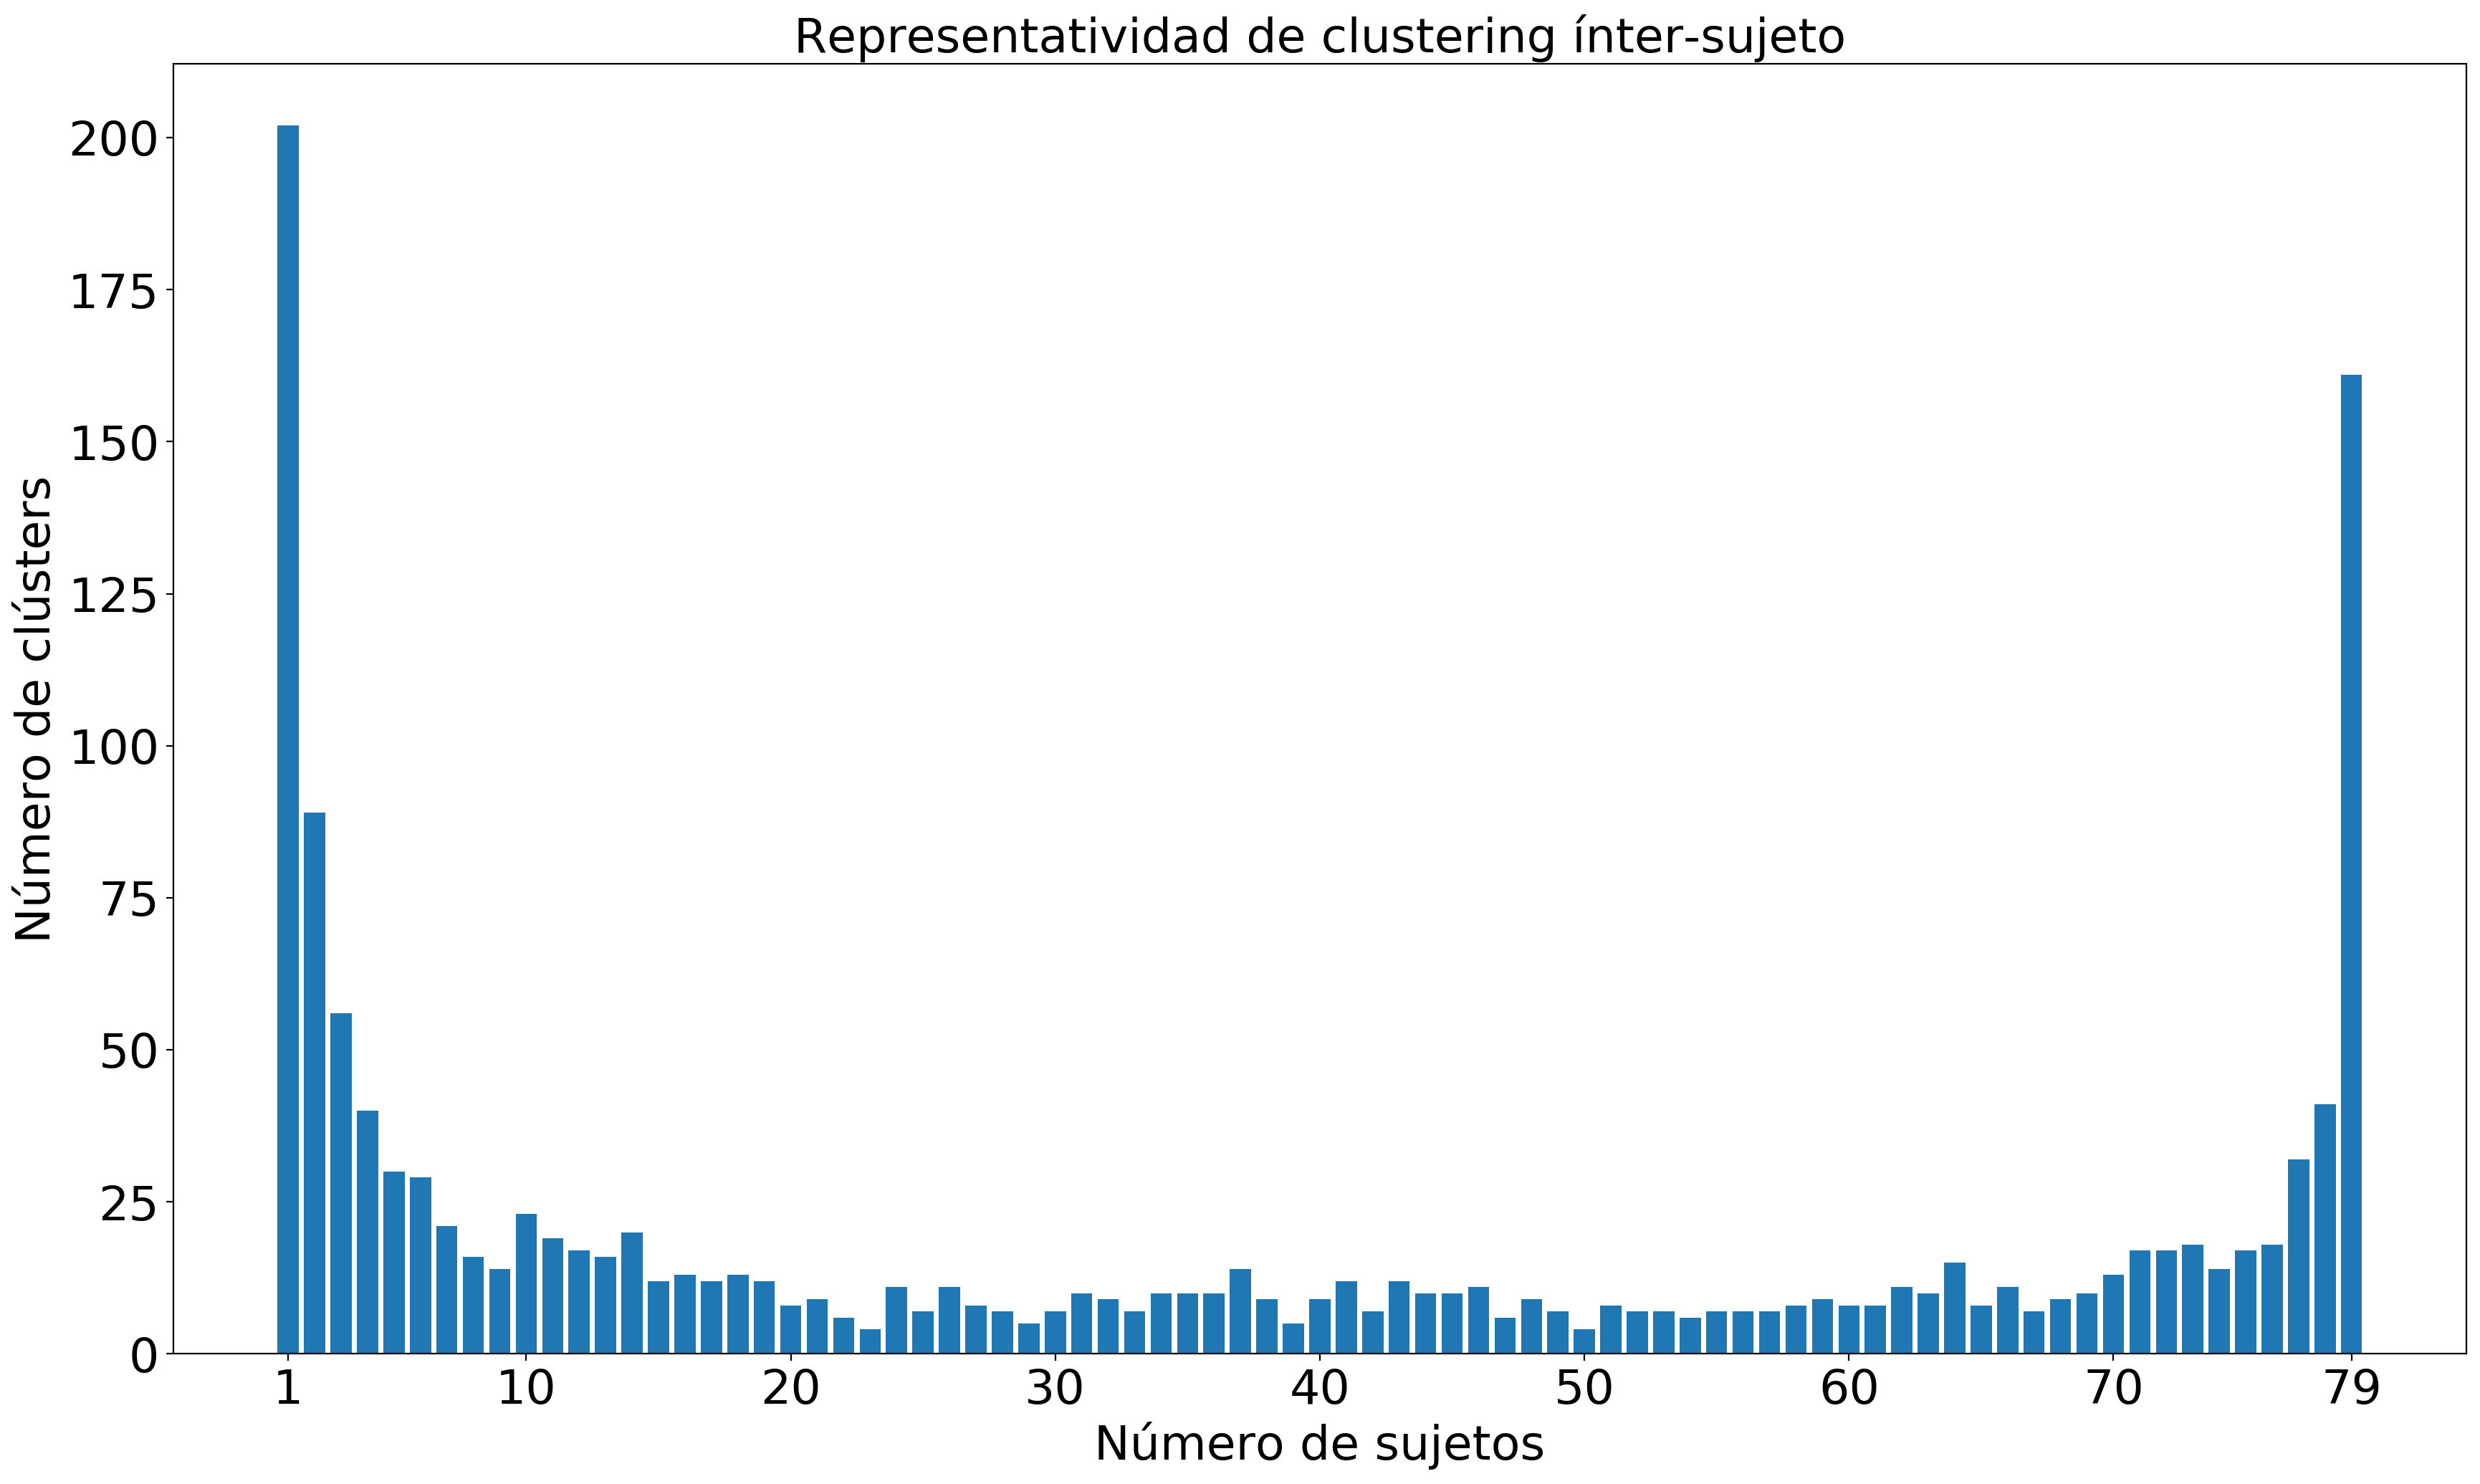

In [67]:
represent = []

for cluster in inter_clusters:
    
    subs = len(set(ids[cluster.indices]))
    
    represent.append(subs)

represent = np.array(represent)

hist = [0]*79

for i in range(0,79):
    hist[i] = np.sum(represent == i+1)

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16,9), dpi = 200)
ax = fig.add_axes([0,0,1,1])
ax.bar(range(1,80), hist[:])

plt.xlabel('Número de sujetos', fontsize = 24)
plt.xticks([1,10,20,30,40,50,60,70,79], fontsize = 24)
plt.yticks(fontsize = 24)
plt.ylabel('Número de clústers', fontsize = 24)
plt.title('Representatividad de clustering ínter-sujeto', fontsize = 24)

fig.savefig('data/79subjects/inter-clustered_QB_' + str(int(theta)) + '2/represent.pdf', dpi = 300, bbox_inches = 'tight')

# fig.bar(range(1,80), hist)

In [20]:
keys = range(1,80)
subs_clusters = {key: [] for key in keys}
subs_centroids = {key: [] for key in keys}
subs_clusters_names = {key: [] for key in keys}
qb_valid_idx = []

subs_thr = 70

for j, cluster in enumerate(inter_clusters):
    
    subs = set(ids[cluster.indices])
    
    if len(subs) < subs_thr:
        continue
    
    qb_valid_idx.append(j)
    
    for sub in subs:
        subs_clusters_names[sub].append('cluster_' + str(j))
    
    subs_temp = {key: [] for key in subs}
    subs_centroid_temp = {key: [] for key in subs}
    
    for idx in cluster.indices:
        subs_centroid_temp[ids[idx]].append(intra_centroids_AS[idx])
        
        for fiber in fibers[idx]:
            subs_temp[ids[idx]].append(fiber)
        
    for sub in subs_temp.keys():
        if subs_centroid_temp[sub] != []:
            subs_centroids[sub].append(subs_centroid_temp[sub])
        if subs_temp[sub] != []:
            subs_clusters[sub].append(subs_temp[sub])

In [26]:
cuales = []
n_intra_centroids = 0
n_intra_fibers = 0

for idx, cluster in enumerate(inter_clusters):
    n_subs = len(set(ids[cluster.indices]))
    
    if n_subs >= 70:
        cuales.append(idx)
        n_intra_centroids += len(cluster.indices)
        for j in range(len(fibers[cluster.indices])):
            n_intra_fibers += len(fibers[cluster.indices][j])

In [73]:
print(n_intra_centroids)
print(n_intra_fibers)

611534
33093801


In [74]:
inter_clusters_names = []

for j, cluster in enumerate(inter_clusters):
    if len(cluster) == 1:
        continue
    inter_clusters_names.append('cluster_' + str(j))

In [75]:
n = len(inter_clusters_names)
paleta = random_palette(n)
write_hie('data/79subjects/inter-clustered_QB_' + str(int(theta)) + '2/QB_' + str(int(theta)) + '.hie', inter_clusters_names, paleta)

In [76]:
n

1316

In [29]:
import os
import utils.bundleTools3 as bt3

inter_path = 'data/79subjects/inter-clustered_QB_' + str(int(theta)) + '2/'

for sub in subs_clusters.keys():
    if sub < 10:
        name = '00' + str(sub)
    else:
        name = '0' + str(sub)
    
    if not os.path.exists(inter_path + name):
        os.makedirs(inter_path + name)
    
    bt3.write_bundle_severalbundles(inter_path + name + '/clusters.bundles', subs_clusters[sub], subs_clusters_names[sub])
    bt3.write_bundle_severalbundles(inter_path + name + '/centroids.bundles', subs_centroids[sub], subs_clusters_names[sub])
    

In [30]:
qb_valid_clusters = []
qb_valid_centroids = []
qb_valid_names = []

for idx in qb_valid_idx:
    
    temp = []
    for centroid in inter_clusters[idx]:
        temp.append(centroid)
    qb_valid_clusters.append(temp)
    
    qb_valid_centroids.append([inter_clusters[idx].centroid])
    qb_valid_names.append('cluster_' + str(idx))
    
bt3.write_bundle_severalbundles(inter_path + 'QB_' + str(int(theta)) + '_centroids.bundles', qb_valid_centroids, qb_valid_names)
bt3.write_bundle_severalbundles(inter_path + 'QB_' + str(int(theta)) + '_clusters.bundles', qb_valid_clusters, qb_valid_names)

In [27]:
len(cuales)

348

In [43]:
n_intra_centroids

598444

In [44]:
len(intra_centroids)

756284

In [24]:
len(np.concatenate(fibers))

37678118

In [21]:
n_intra_fibers

24275156

In [22]:
n_intra_fibers

24275156

In [23]:
len(inter_clusters[0].indices)

553

In [24]:
len(fibers[inter_clusters[0].indices])

553

In [25]:
len(fibers[inter_clusters[0].indices][1])

18

In [26]:
len(inter_clusters[0].indices)

553

In [27]:
intra_centroids.shape

(756284, 21, 3)

In [29]:
n_intra_centroids

426727

In [8]:
n_clusters = 0
n_fibers = 0

for i in range(79):
    for j in range(len(subs_clusters[i+1])):
        n_fibers += len(subs_clusters[i+1][j])
    n_clusters += len(subs_clusters[i+1])
        
print('Finalmente, restan ' + str(n_clusters) + ' clusters')
print('Correspondientes a ' + str(n_fibers) + ' fibras')

Finalmente, restan 26715 clusters
Correspondientes a 33093801 fibras


In [58]:
import os
import random

inter_path = 'data/79subjects/inter-clustered_QB_' + str(int(theta)) + '/'

for sub in subs_clusters.keys():
    if sub < 10:
        name = '00' + str(sub)
    else:
        name = '0' + str(sub)
    
    if not os.path.exists(inter_path + name):
        os.makedirs(inter_path + name)
    
    write_bundles(inter_path + name + '/clusters.bundles', subs_clusters[sub])
    write_bundles(inter_path + name + '/centroids.bundles', subs_centroids[sub])

#write_bundles(inter_path + 'test.bundles', subs_clusters[1])

86
86
86
86
93
93
93
93
109
109
109
109
108
108
108
108
116
116
116
116
116
116
116
116
121
121
121
121
120
120
120
120
120
120
120
120
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
124
124
124
124
125
125
125
125
123
123
123
123
124
124
124
124
124
124
124
124
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
123
123
123
123
124
124
124
124
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
124
124
124
124
125
125
125
125
125
125
125
125
124
124
124
124
125
125
125
125
125
125
125
125
124
124
124
124
125
125
125
125
125
125
125
125
124
124
124
124
125
125
125
125
125
125
125
125
124
124
124
124
123
123
123
123
124
124
124
124
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
125
124
124
124
124
125
125
125
125
123
123
123
123
125
125
125
125
124
124
124
124
124
124
124
124
125
125
125
125
124
124
124
124
125
125
125
125
124
124
124
124
125
125
125
125
125
125
125
125
125
125
125
125
123
123
123
123
124
124
124
124
125
125
125
125
